In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

from pa_lib.job import request_job
from pa_lib.file import project_dir, load_bin, load_csv
from pa_lib.data import desc_col
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np
from pa_lib.vis import boxplot_histogram

import seaborn as sns

import urlopen

sns.set_style("darkgrid")

import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"
import plotly.express as px

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os

C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython\stc
C:\Users\stc\Documents\GitHub\DataScienceAPG\PredictiveAnalyticsPython
200


# Global Variables

In [2]:
BASELINE_DATE = pd.to_datetime("13.01.2020",format="%d.%m.%Y")
LOCKDOWN_DATE = pd.to_datetime("13.3.2020",format="%d.%m.%Y")
display(LOCKDOWN_DATE)

# Load data

In [3]:
DATA_DIR = Path.home() / "data" / "dashboard-corona"

In [4]:
DATA_DIR

WindowsPath('C:/Users/stc/data/dashboard-corona')

In [5]:
apple_df = pd.read_feather(DATA_DIR / "apple_mobility_data.feather")
zh_hardbruecke_df = pd.read_feather(DATA_DIR / "hardbruecke_data.feather")
zh_fussvelo_df = pd.read_feather(DATA_DIR / "passanten_velo_sum.feather")
zh_auto_df = pd.read_feather(DATA_DIR / "verkehrsdaten_median.feather")


In [6]:
container_df = apple_df.loc[
    apple_df.region.isin(["Zurich","Switzerland"]),
    ["date","region","transportation_type", "percent"]
].rename(columns={
    "percent": "apple_percent",
    "transportation_type": "type"}
        ).eval("apple_percent = apple_percent - 100")

container_df = (pd.pivot_table(container_df,
               values="apple_percent",
               columns="region",
               index=["date","type"])
           .reset_index()
           .rename(columns={"Switzerland": "apple_ch_percent",
                            "Zurich": "apple_zh_percent"})
           .rename_axis(None,inplace=False))

In [7]:
zh_transit_df = zh_hardbruecke_df.loc[:,["Date", "Trend"]].rename(
    columns={"Date": "date","Trend": "zh_percent"})
zh_transit_df.loc[:,"type"] = "transit"

zh_walking_df = zh_fussvelo_df.loc[:,["date","trend"]].rename(
    columns={"trend": "zh_percent"}
)
zh_walking_df.loc[:,"type"] = "walking"

auto_baseline_value = (zh_auto_df.loc[
    zh_auto_df.date == BASELINE_DATE,
    "AnzFahrzeuge"].values[0]
                      )
zh_auto_series = ((zh_auto_df.AnzFahrzeuge - auto_baseline_value)
                  / auto_baseline_value *100)

zh_driving_df = pd.DataFrame({"date": zh_auto_df.date, "zh_percent": zh_auto_series, "type": "driving"})

zh_fusion_df = pd.concat([zh_transit_df,zh_walking_df, zh_driving_df]).astype({"date": "datetime64[ns]"})

In [37]:
combination_df = pd.merge(container_df,
                          zh_fusion_df, 
                          left_on=["date","type"],
                          right_on=["date","type"],
                          how="left")
lockdown_flag= (combination_df.date > LOCKDOWN_DATE)

combination_df.loc[:,"lockdown_flag"] = lockdown_flag

In [38]:
combination_df.loc[combination_df.zh_percent.isna()]


,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
95,2020-02-13,walking,9.24,3.48,NaN,False
98,2020-02-14,walking,28.90,21.96,NaN,False
101,2020-02-15,walking,36.98,26.49,NaN,False
104,2020-02-16,walking,-4.71,-14.32,NaN,False
107,2020-02-17,walking,5.70,-2.37,NaN,False


In [39]:
combination_df.sample(200)

,date,type,apple_ch_percent,apple_zh_percent,zh_percent,lockdown_flag
341,2020-05-05,walking,-35.06,-37.65,-58.802004,True
107,2020-02-17,walking,5.70,-2.37,NaN,False
164,2020-03-07,walking,23.30,28.07,-16.475918,False
157,2020-03-05,transit,-2.15,-4.69,-4.042938,False
52,2020-01-30,transit,2.47,-0.85,5.724294,False
...,...,...,...,...,...,...
47,2020-01-28,walking,0.81,-2.65,-29.282388,False
191,2020-03-16,walking,-34.75,-33.58,-2.641043,True
198,2020-03-19,driving,-44.90,-39.52,-26.482213,True
277,2020-04-14,transit,-67.76,-64.29,-62.345763,True


# Simple lineplot

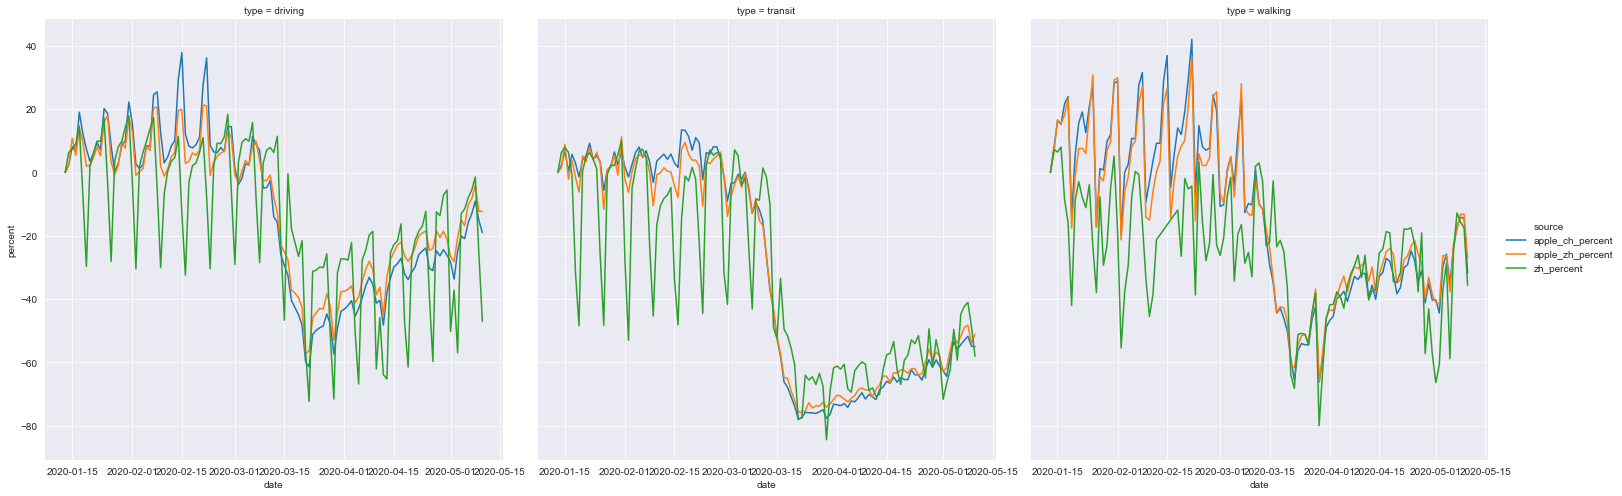

In [211]:
plot_data = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            )

sns.relplot(x="date",
            y="percent",
            hue="source",
            col="type",
            kind="line",
            data=plot_data,
            col_wrap=3,
            height=7)

# Correlation

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9


In [56]:
(combination_df.groupby(["type","lockdown_flag"]).corr(method="pearson",)*100).style.format('{0:,.1f}')

In [17]:
(combination_df[combination_df.date > LOCKDOWN_DATE]
 .groupby("type")
 .corr(method="pearson"))

apple_ch_percent  apple_zh_percent  zh_percent
type                                                                    
driving apple_ch_percent          1.000000          0.995874    0.531865
        apple_zh_percent          0.995874          1.000000    0.548746
        zh_percent                0.531865          0.548746    1.000000
transit apple_ch_percent          1.000000          0.991420    0.714678
        apple_zh_percent          0.991420          1.000000    0.706900
        zh_percent                0.714678          0.706900    1.000000
walking apple_ch_percent          1.000000          0.984703    0.772110
        apple_zh_percent          0.984703          1.000000    0.775851
        zh_percent                0.772110          0.775851    1.000000

In [159]:
combination_df.corr(method="pearson")

,apple_ch_percent,apple_zh_percent,zh_percent
apple_ch_percent,1.000000,0.992776,0.810862
apple_zh_percent,0.992776,1.000000,0.834269
zh_percent,0.810862,0.834269,1.000000


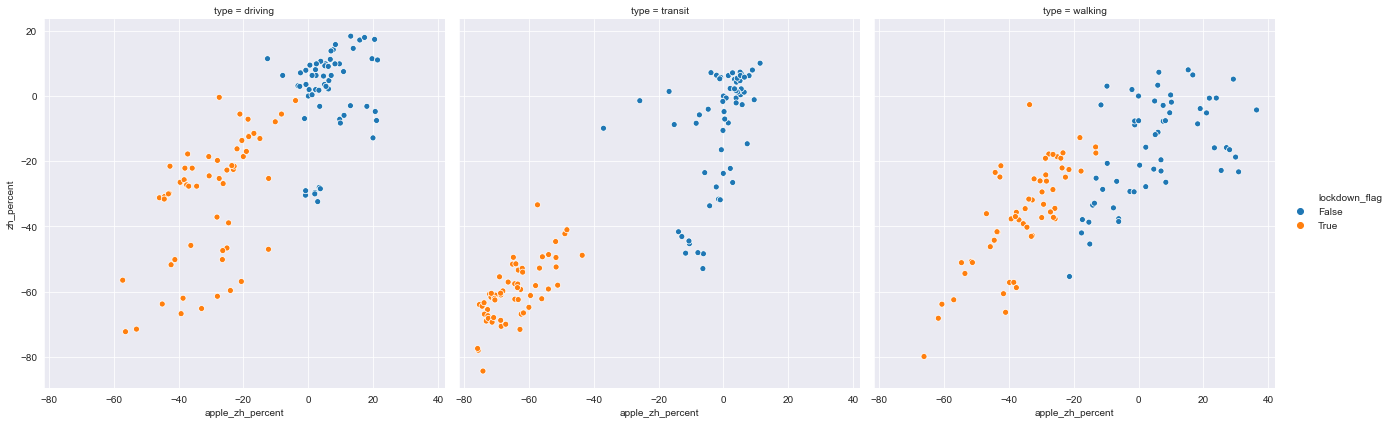

In [212]:
sns.relplot(x="apple_zh_percent",
            y="zh_percent",
            col="type",
            hue="lockdown_flag",
            data=combination_df,
            col_wrap=3,
            height=6)

False
True


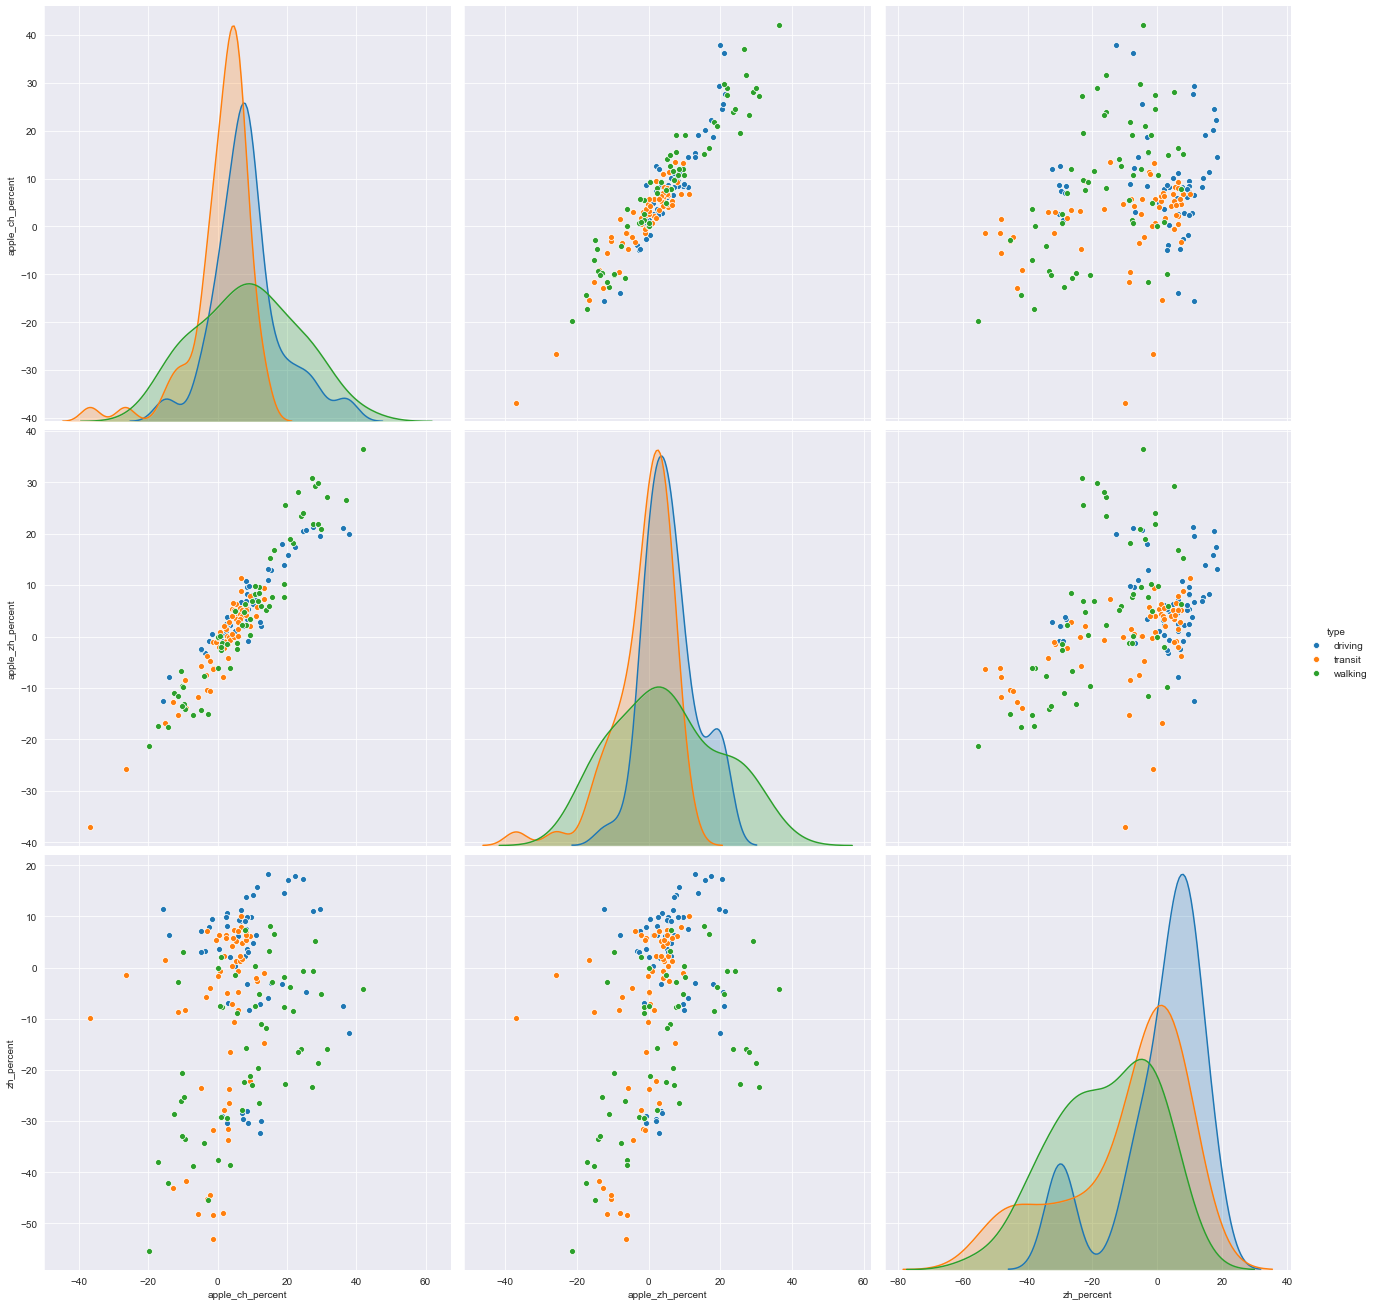

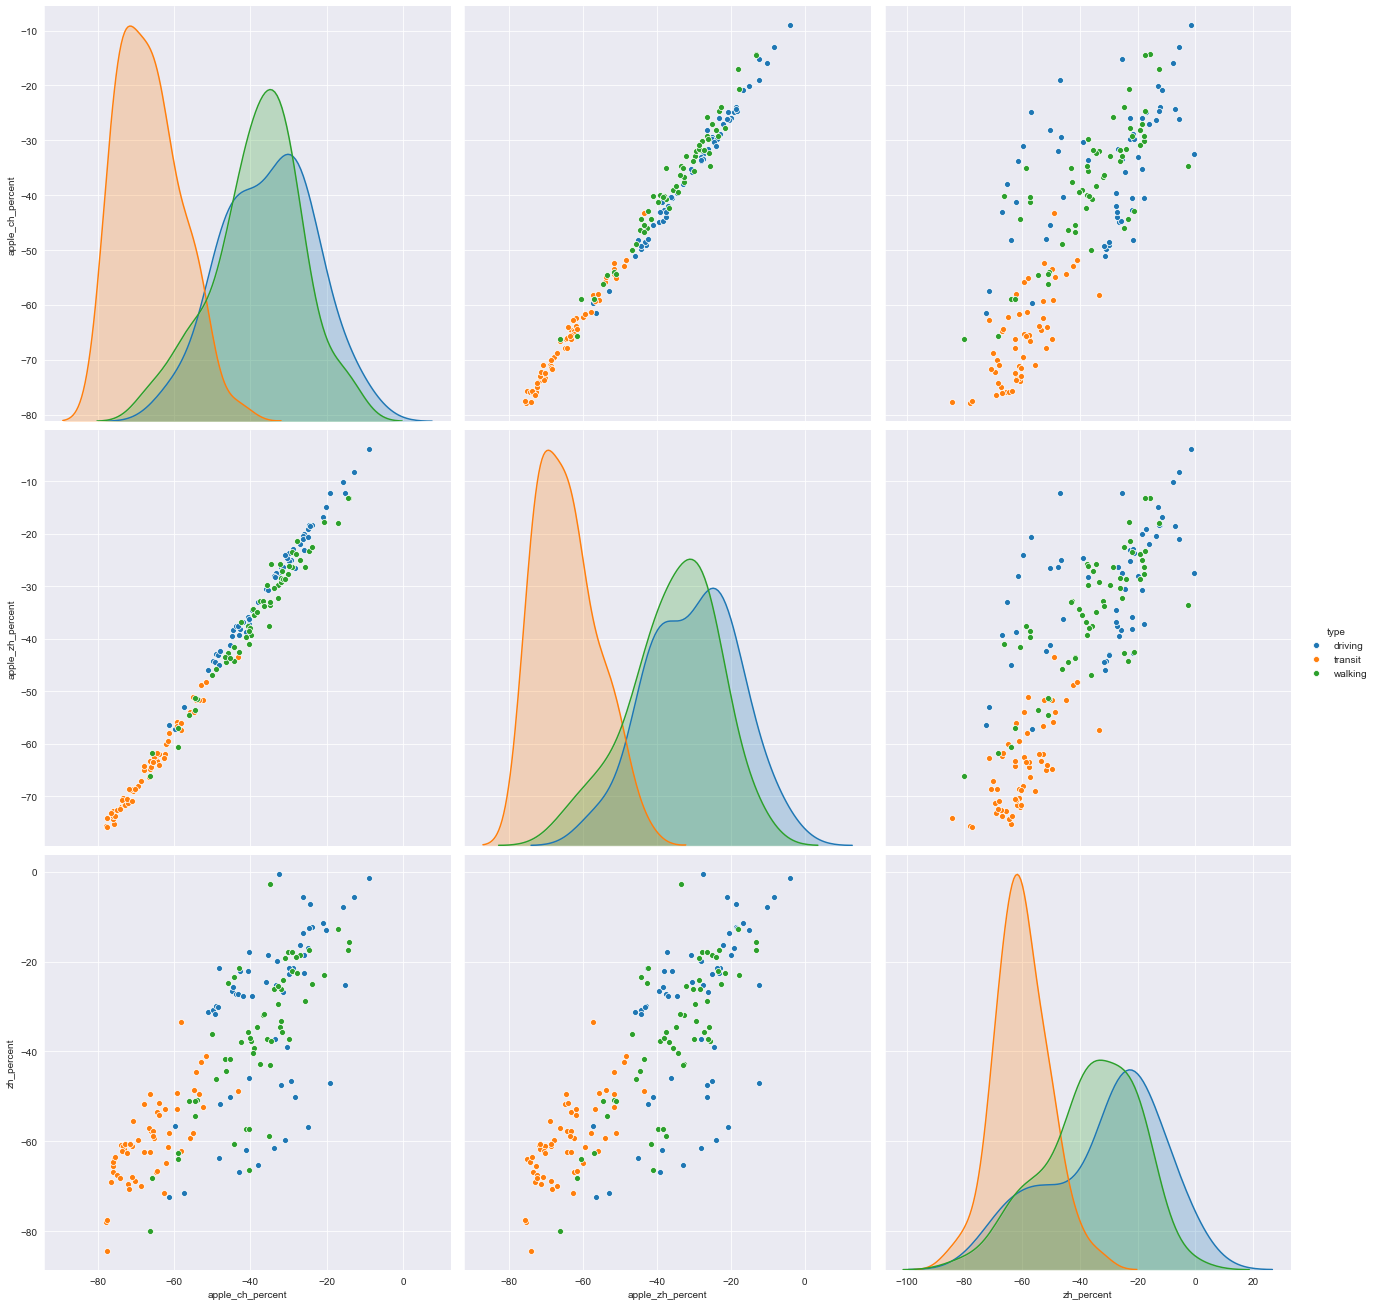

In [49]:
for flag,plot_data in combination_df.groupby("lockdown_flag"):
    print(flag)
    sns.pairplot(plot_data.drop(columns="lockdown_flag"),hue="type",height=6,)

# Seasonal Decomposition

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

## Additive Decomposition

In [210]:
combination_melted_df = (combination_df.melt(id_vars=["date","type","lockdown_flag"])
             .rename(columns={"variable":"source", "value": "percent"})
            ).sort_values("date")

grouped_dataset = combination_melted_df.groupby(["type","source"])

seasonal_decomposition_df = pd.DataFrame()
for x in grouped_dataset:
    temp_df = x[1].copy()
    temp_df.loc[:,"type"]= x[0][0]
    temp_df.loc[:,"source"] = x[0][1]

    observations = temp_df.percent
    observations_imputated = observations.fillna(observations.shift(7))
    
    result = seasonal_decompose(observations_imputated, model='additive', period=7,)
    
    temp_df.loc[:,"trend"] = result.trend
    temp_df.loc[:,"seasonal"] = result.seasonal
    temp_df.loc[:,"residues"] = result.resid
    
    seasonal_decomposition_df = pd.concat([seasonal_decomposition_df,temp_df])

In [193]:
seasonal_decomposition_df

,date,type,lockdown_flag,source,percent,trend,seasonal,residues
0,2020-01-13,driving,False,apple_ch_percent,0.000000,NaN,-3.851953,NaN
3,2020-01-14,driving,False,apple_ch_percent,2.350000,NaN,-2.623739,NaN
6,2020-01-15,driving,False,apple_ch_percent,8.160000,NaN,0.395547,NaN
9,2020-01-16,driving,False,apple_ch_percent,6.470000,7.942857,-0.043996,-1.428861
12,2020-01-17,driving,False,apple_ch_percent,19.060000,8.450000,6.305190,4.304810
...,...,...,...,...,...,...,...,...
1058,2020-05-06,walking,True,zh_percent,-24.897475,-27.936179,4.336038,-1.297333
1061,2020-05-07,walking,True,zh_percent,-12.766092,-27.698412,7.117788,7.814532
1064,2020-05-08,walking,True,zh_percent,-15.639314,NaN,8.071518,NaN
1067,2020-05-09,walking,True,zh_percent,-17.498013,NaN,0.203032,NaN


## Simple lineplot

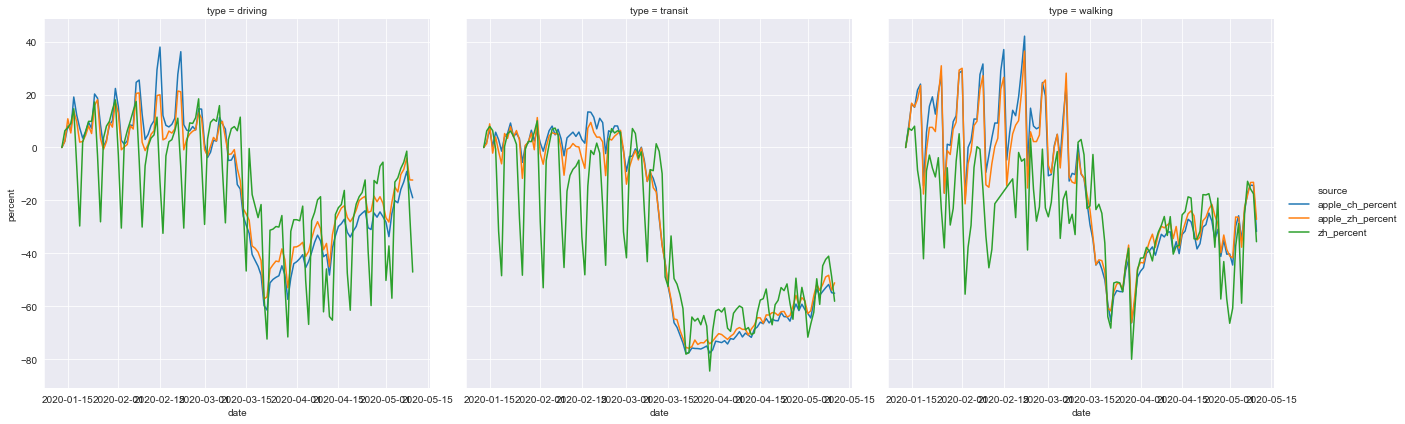

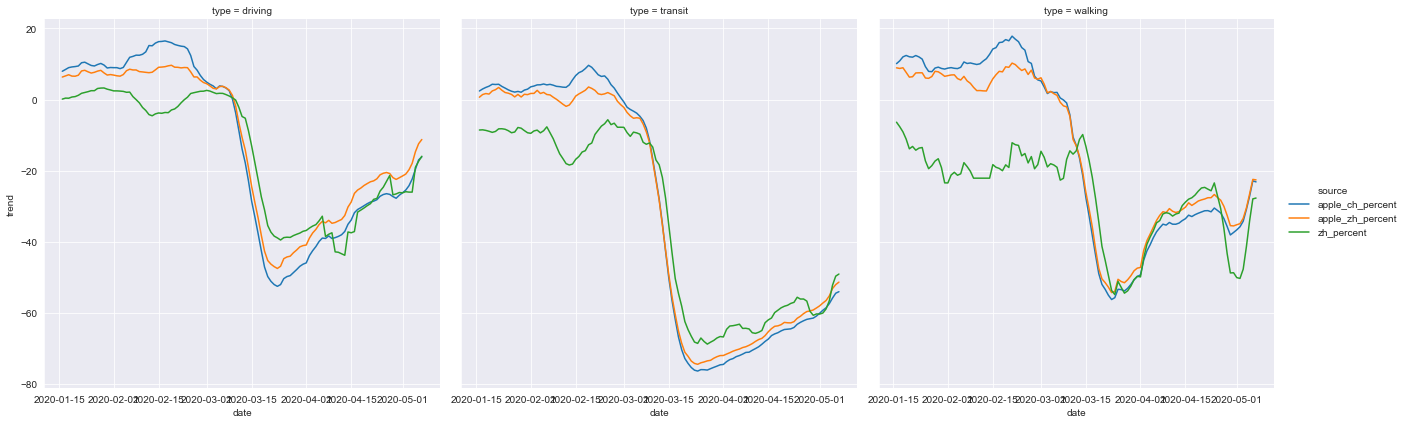

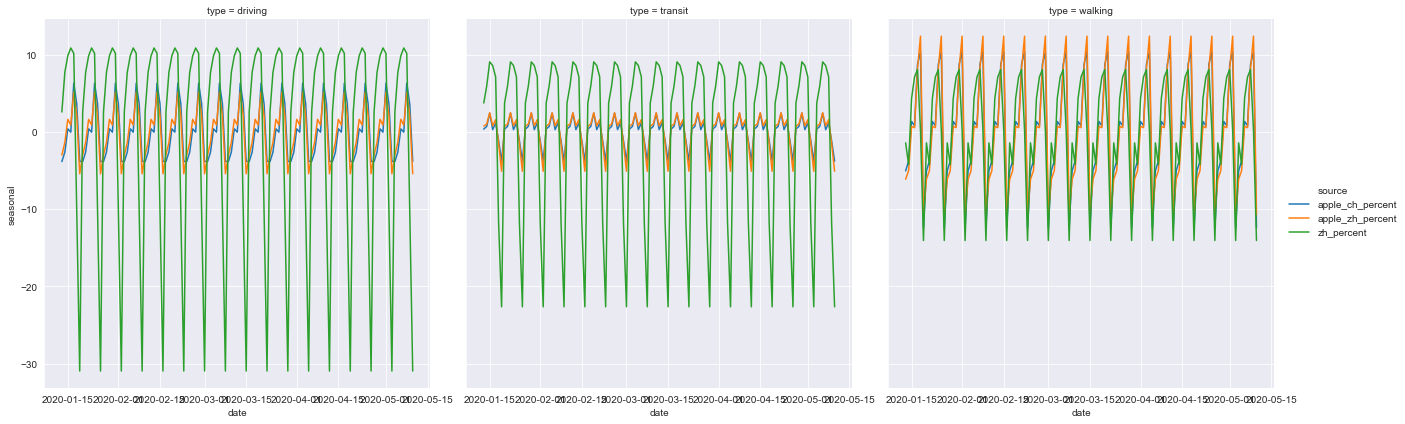

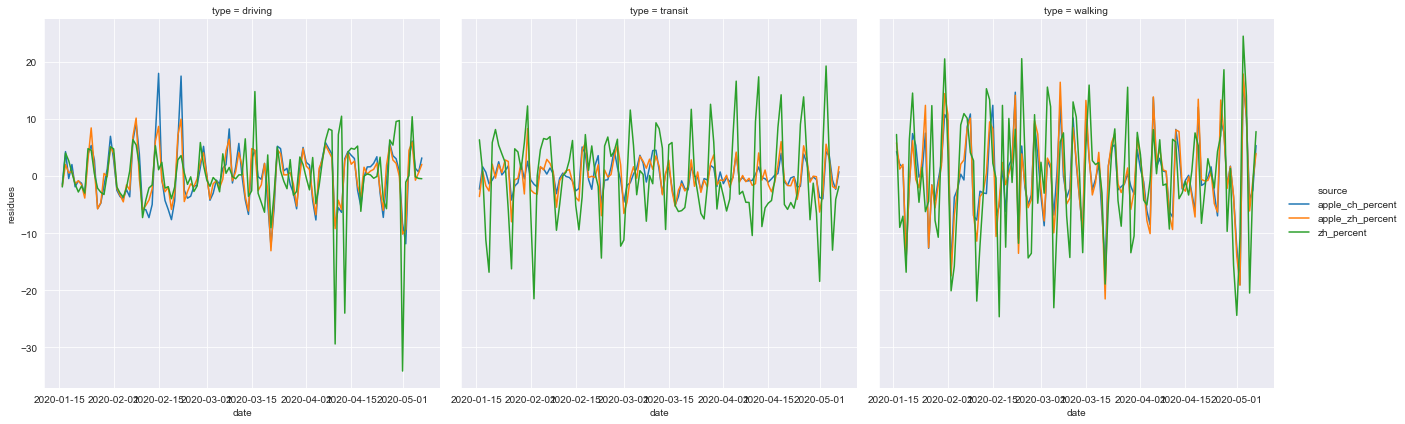

In [198]:
for y_values in ["percent","trend","seasonal","residues"]:
    sns.relplot(x="date",
            y=y_values,
            hue="source",
            col="type",
            kind="line",
            data=seasonal_decomposition_df,
            col_wrap=3,
            height=6)

## Correlation on Trend

In [220]:
correlate_this = (pd.pivot_table(seasonal_decomposition_df,
                values="trend",
                columns=["source"],
                index=['date', 'type', 'lockdown_flag'])
 .reset_index()
)

(correlate_this.drop(columns="lockdown_flag").groupby("type").corr(method="pearson")*100).style.format('{0:,.0f}')